In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
import plotly.graph_objs as go

import seaborn as sns
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# remove warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import merged data without the index column
df = pd.read_csv('merged_df.csv', index_col=None)

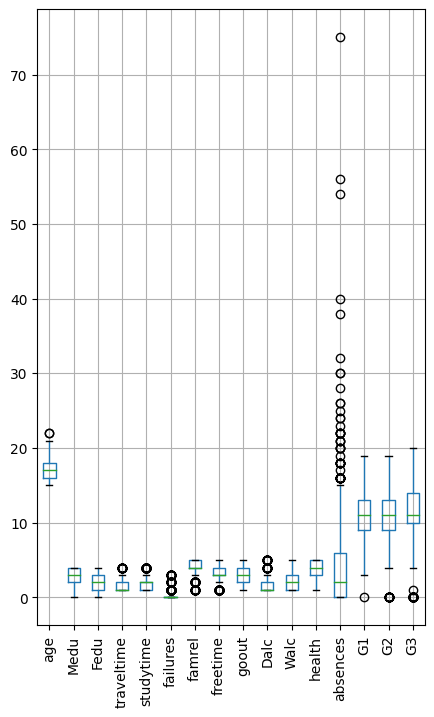

In [3]:
# analyze the data to find outliers 
# plot box plots for each column
df.boxplot(figsize=(5,8), rot=90)
plt.show()

In [4]:
# looking column absences outlier statiscally
df['absences'].describe()
# remove outliers
df = df[df['absences'] < 20]

## Transform the data
*   Create two datasets one for categorical and another for numerical columns.
*   Usage of the method get_dummies() to convert categorical columns into numerical columns.
*   Concatenation of the two datasets before standardization.
*   Usage of the method StandardScaler() to scale making all the values been between 0 and 1.
*   Usage of method StandardScaler() to scale the numerical columns.

In [5]:
# Making 2 dataframes for categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object', 'category'])
continuous_cols = df[['age', 'absences']]

# remove the targets columns that wont be used for our clustering
categorical_cols = categorical_cols.drop(['absences_range', 'academicGrade'], axis=1)

In [6]:
# Transform categorical columns with the method get_dummies,
# and left out target 'finalresult', 'G1'... and continuous columns also unnecessary columns.
categorical_cols = pd.get_dummies(df[df.columns[~df.columns.isin(['age', 
                                                                  'absences', 'absences_range', 'academicGrade', 'finalResult', 'G3'])]])

# transform from true and false to 1 and 0
categorical_cols = categorical_cols.astype(int)


In [7]:
## Try without normalization
# concatenate categorical and continuous columns
num_scaled = pd.concat([categorical_cols, continuous_cols], axis=1)

df_final = num_scaled.copy()
# normalize the data

## Try with normalization
scaler = MinMaxScaler()
df_final = pd.DataFrame(scaler.fit_transform(num_scaled), columns=num_scaled.columns)

In [8]:
df_final.head()

,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,...,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes,age,absences
0,1.00,1.00,0.333333,0.333333,0.0,0.75,0.50,0.75,0.00,0.00,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.428571,0.315789
1,0.25,0.25,0.000000,0.333333,0.0,1.00,0.50,0.50,0.00,0.00,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.285714,0.210526
2,0.25,0.25,0.000000,0.333333,1.0,0.75,0.50,0.25,0.25,0.50,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.000000,0.526316
3,1.00,0.50,0.000000,0.666667,0.0,0.50,0.25,0.25,0.00,0.00,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.000000,0.105263
4,0.75,0.75,0.000000,0.333333,0.0,0.75,0.50,0.25,0.00,0.25,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.142857,0.210526


### Find out the most appropriate numbers of cluster using Elbow methods

In [9]:
# get index of the category columns
cat_cols_index = [df_final.columns.get_loc(c) for c in categorical_cols.columns if c in df_final]

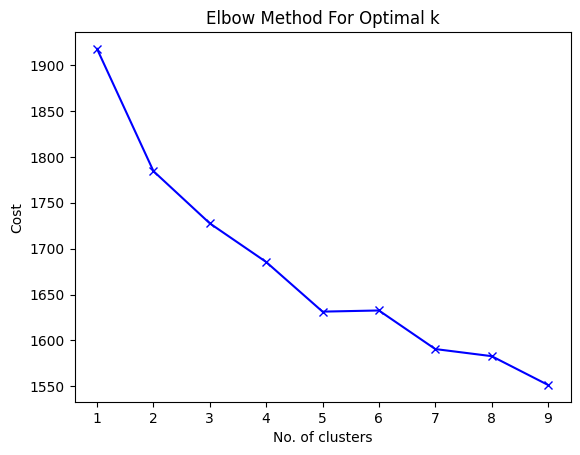

In [10]:
from kmodes.kmodes import KModes
# Elbow curve to find optimal K
cost = []
K = range(1,10)
for num_clusters in list(K):
    kmode = KPrototypes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=0)
    kmode.fit_predict(df_final, categorical= cat_cols_index)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()


In [11]:
final_model = KPrototypes( n_clusters=5, random_state=42).fit(df_final, categorical= cat_cols_index)
final = final_model.predict(df_final, categorical= cat_cols_index)

### Visualize the clusters of G1 and G2

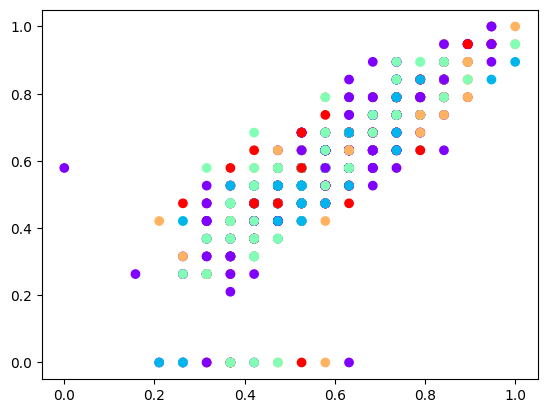

In [12]:
# apply ACM to reduce the dimensionality of the data

import prince 
from prince import mca

# apply mca to the categorical columns and select the number of components


mca = mca.MCA( n_components=2)
mca = mca.fit(df_final[categorical_cols.columns])
mca = mca.transform(df_final[categorical_cols.columns])


from sklearn.decomposition import PCA
pca = PCA(n_components=2)

# apply pca to the continuous columns
pca.fit(df_final[['age', 'absences']])
pca = pca.transform(df_final[['age', 'absences']])

# concatenate the results
final = np.concatenate((mca, pca), axis=1)

# plot all the columns in 2D

plt.scatter(df_final['G1'], df_final['G2'], c=final_model.labels_, cmap='rainbow')

plt.show()


### Analyze the weights of each features our 5 groups

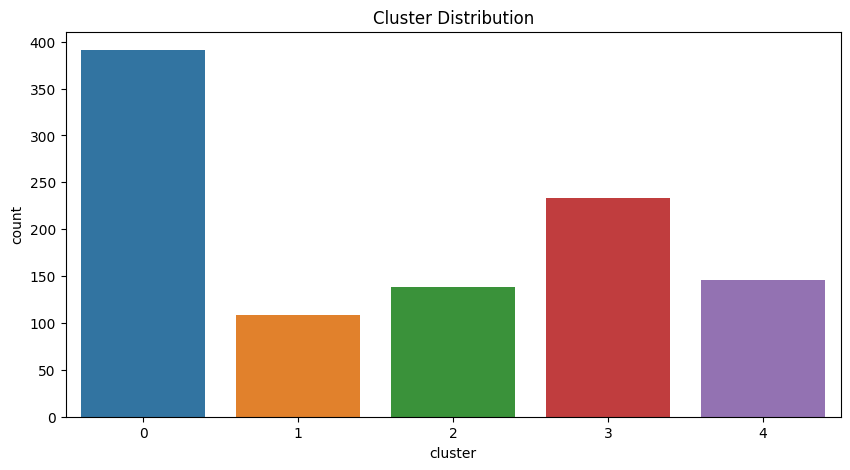

cluster                 0         1         2         3         4
higher_yes       0.938619  0.871560  0.826087  0.982833  0.869863
paid_no          0.854220  0.935780  0.913043  0.472103  0.924658
Pstatus_T        0.849105  0.917431  0.869565  0.901288  0.952055
schoolsup_no     0.841432  0.917431  0.956522  0.866953  0.938356
nursery_yes      0.841432  0.862385  0.826087  0.888412  0.472603
school_GP        0.838875  0.403670  0.239130  0.918455  0.863014
sex_F            0.838875  0.293578  0.731884  0.339056  0.226027
internet_yes     0.828645  0.816514  0.405797  0.922747  0.801370
address_U        0.826087  0.752294  0.260870  0.789700  0.767123
famsup_yes       0.790281  0.321101  0.347826  0.845494  0.219178
famsize_GT3      0.757033  0.330275  0.775362  0.751073  0.712329
activities_no    0.754476  0.715596  0.384058  0.180258  0.301370
guardian_mother  0.723785  0.376147  0.746377  0.742489  0.753425
famrel           0.719309  0.733945  0.726449  0.740343  0.768836
Fjob_other

In [13]:
df_final['cluster'] = final_model.labels_
cluster_counts = df_final["cluster"].value_counts()

# plot like points with a value count of each cluster
plt.figure(figsize=(10,5))

sns.countplot(x=df_final['cluster'], data=df_final)
plt.title('Cluster Distribution')
plt.show()

explain_cluster = df_final.groupby('cluster').mean().T.nlargest(20, 0)

print(explain_cluster)


## Conclusion of Clustering

- Cluster 0: This cluster is characterized by students who have a higher education level among their parents, are less likely to receive extra paid classes, and are more likely to have parents who are living apart. They also tend to have less support from their family and are less likely to have internet access at home. This cluster is labeled as "High Education, Low Support."

- Cluster 1: This cluster is characterized by students who are less likely to attend a GP school, have a female gender, and have internet access at home. They are also less likely to receive extra paid classes, have less family support, and have mothers as their guardians. This cluster is labeled as "Female, Low Education, Less Support."

- Cluster 2: This cluster is characterized by students who are more likely to attend a GP school, have received extra paid classes, and have internet access at home. They also tend to have larger families, have parents who are living together, and have more support from their family. This cluster is labeled as "High Education, High Support."

- Cluster 3: This cluster is characterized by students who are more likely to have good health and study well in G2 and G1. However, they are less likely to receive extra paid classes, have less support from their family, and have less internet access at home. This cluster is labeled as "Good Health, Good Study, Less Support."

- Cluster 4: This cluster is characterized by students who are less likely to attend a GP school, have less family support, and are less likely to have internet access at home. They also tend to have larger families and have fathers who work in "other" fields. This cluster is labeled as "Large Family, Less Support."

## Classification algorithms for binary classes 
* SVM
* Linear discriminant analysis
* Logistic regression classifier
* Decision tree classifier
* Voting classifier

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from json_config_expander import expand_configs
from xgboost import XGBClassifier

In [15]:
df['finalResult']

0       fail
1       fail
2       pass
3       pass
4       pass
        ... 
1039    pass
1040    pass
1041    fail
1042    pass
1043    pass
Name: finalResult, Length: 1017, dtype: object

In [16]:
# drop clusters column and finalResult column
df_final = df_final.drop(['cluster'], axis=1)

# define X and y
X = df_final
#X = df_final[df_final.columns[~df_final.columns.isin(['finalResult'])]]
y = df['finalResult']

# Transform into binary classification problem
y = y.map({'fail': 0, 'pass': 1})

In [17]:
# Check if the labels are balanced
y.value_counts()

finalResult
1    799
0    218
Name: count, dtype: int64

### Rebalance the dataset with the SMOTE method

In [18]:
# Using SMOTE to balance the labels
from imblearn.over_sampling import SMOTE

# SMOTE works by selecting examples that are close in the feature space, drawing 
# a line between the examples in the feature space and drawing a new sample at a point along that line.

# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

# Check if the labels are balanced
y.value_counts()

finalResult
0    799
1    799
Name: count, dtype: int64

### Training and testing the model

In [19]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

SVC classifier

In [20]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def training_pipeline(clf , X_train, y_train, X_test, y_test, param_grid):
    # Define hyperparameter grid
    # Perform grid search for best parameters
    grid = GridSearchCV(clf, param_grid, refit=True)
    grid.fit(X_train, y_train)
    # Print best parameter after tuning
    print(f"Best parameters: {grid.best_params_}")
    # Print classification report and confusion matrix for training set
    X_train_result = grid.predict(X_train)
    print(f"Classification report for training set:\n{classification_report(y_train, X_train_result)}")
    cm_train = confusion_matrix(y_train, X_train_result)
    sns.heatmap(cm_train, annot=True)
    plt.show()
    # Evaluate model on testing set and print results
    grid_predictions = grid.predict(X_test)
    print(f"Classification report for testing set:\n{classification_report(y_test, grid_predictions)}")
    cm_test = confusion_matrix(y_test, grid_predictions)
    sns.heatmap(cm_test, annot=True)
    plt.show()


Best parameters: {'C': 1000, 'gamma': 0.01}
Classification report for training set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       646
           1       1.00      1.00      1.00       632

    accuracy                           1.00      1278
   macro avg       1.00      1.00      1.00      1278
weighted avg       1.00      1.00      1.00      1278



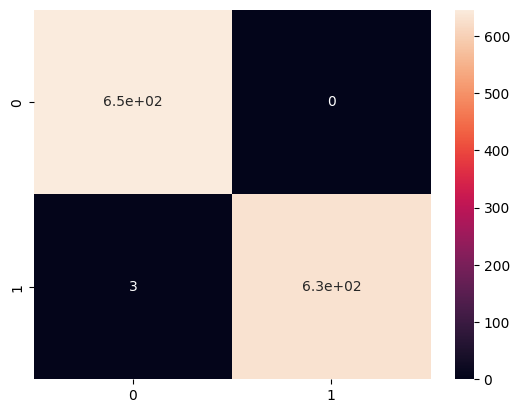

Classification report for testing set:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       153
           1       0.99      0.94      0.97       167

    accuracy                           0.97       320
   macro avg       0.97      0.97      0.97       320
weighted avg       0.97      0.97      0.97       320



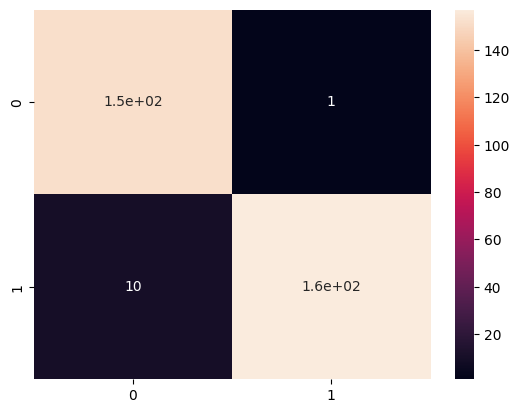

In [21]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
clf = SVC()
training_pipeline(clf, X_train, y_train, X_test, y_test, param_grid= param_grid)

Linear discriminant analysis

Best parameters: {'solver': 'svd'}
Classification report for training set:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       646
           1       0.97      0.88      0.92       632

    accuracy                           0.92      1278
   macro avg       0.93      0.92      0.92      1278
weighted avg       0.93      0.92      0.92      1278



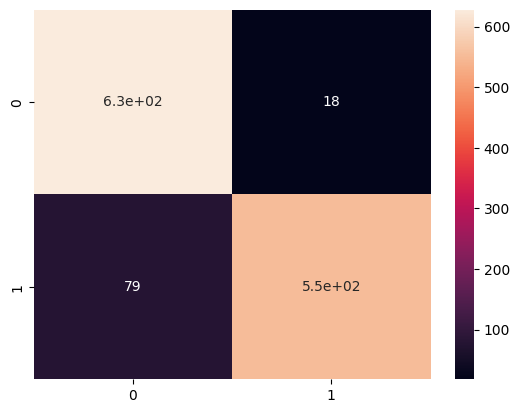

Classification report for testing set:
              precision    recall  f1-score   support

           0       0.81      0.96      0.88       153
           1       0.96      0.79      0.87       167

    accuracy                           0.87       320
   macro avg       0.88      0.88      0.87       320
weighted avg       0.89      0.87      0.87       320



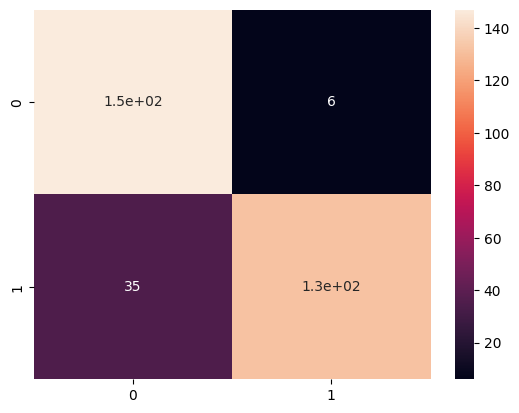

In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
param_grid = {'solver': ['svd', 'lsqr', 'eigen']}
clf = LinearDiscriminantAnalysis()

training_pipeline(clf, X_train, y_train, X_test, y_test, param_grid= param_grid)

Logistic regression classifier

Best parameters: {'C': 100, 'solver': 'sag'}
Classification report for training set:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       646
           1       0.96      0.93      0.94       632

    accuracy                           0.94      1278
   macro avg       0.94      0.94      0.94      1278
weighted avg       0.94      0.94      0.94      1278



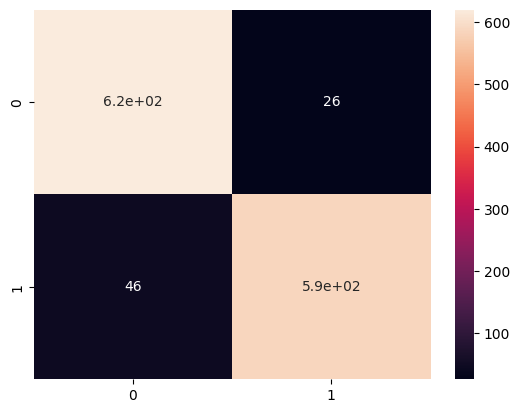

Classification report for testing set:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       153
           1       0.97      0.91      0.94       167

    accuracy                           0.94       320
   macro avg       0.94      0.94      0.94       320
weighted avg       0.94      0.94      0.94       320



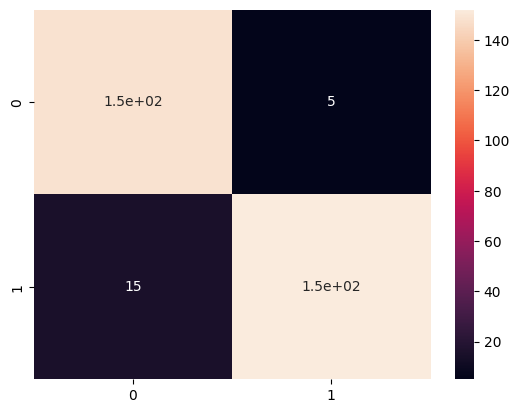

In [23]:
# Testing logistic regression classifier
from sklearn.linear_model import LogisticRegression

param_grid = {'C': [0.1, 1, 10, 100, 1000], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
clf = LogisticRegression()

training_pipeline(clf, X_train, y_train, X_test, y_test, param_grid= param_grid)

Decision tree classifier

Best parameters: {'criterion': 'gini', 'max_depth': 2}
Classification report for training set:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       646
           1       0.95      0.91      0.93       632

    accuracy                           0.93      1278
   macro avg       0.93      0.93      0.93      1278
weighted avg       0.93      0.93      0.93      1278



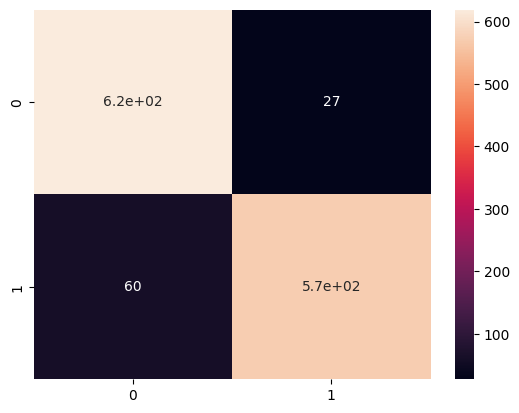

Classification report for testing set:
              precision    recall  f1-score   support

           0       0.88      0.97      0.93       153
           1       0.97      0.88      0.92       167

    accuracy                           0.93       320
   macro avg       0.93      0.93      0.92       320
weighted avg       0.93      0.93      0.92       320



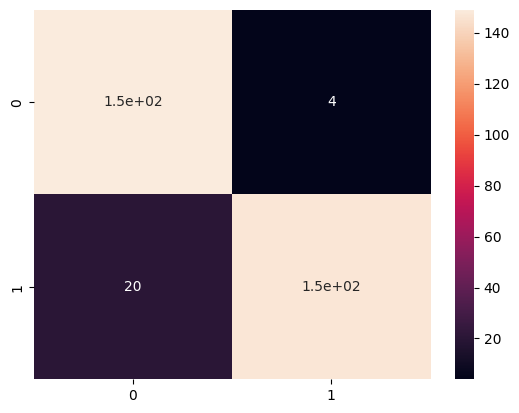

In [24]:
# Testing Decision Tree classifier
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [2, 4, 6, 8, 10, 12, 14, 16]}

training_pipeline(clf, X_train, y_train, X_test, y_test, param_grid= param_grid)

 Voting classifier

In [27]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV

# Define classifiers to use in the VotingClassifier
clf1 = LogisticRegression()
clf2 = LinearDiscriminantAnalysis()
clf3 = DecisionTreeClassifier()
clf4 = SVC()

# Define the parameter grid for each classifier
param_grid1 = {'C': [0.1, 1, 10, 100, 1000], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
param_grid2 = {'solver': ['svd', 'lsqr', 'eigen']}
param_grid3 = {'criterion': ['gini', 'entropy'], 'max_depth': [2, 4, 6, 8, 10, 12, 14, 16]}
param_grid4 = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

# Perform grid search for each classifier
grid1 = GridSearchCV(clf1, param_grid1, refit=True)
grid1.fit(X_train, y_train)

grid2 = GridSearchCV(clf2, param_grid2, refit=True)
grid2.fit(X_train, y_train)

grid3 = GridSearchCV(clf3, param_grid3, refit=True)
grid3.fit(X_train, y_train)

grid4 = GridSearchCV(clf4, param_grid4, refit=True)
grid4.fit(X_train, y_train)
# Define the voting classifier using the best hyperparameters for each classifier
voting_clf = VotingClassifier(
    estimators=[('LogisticRegression', grid1.best_estimator_), ('LinearDiscriminant', grid2.best_estimator_), 
                ('DecisionTree', grid3.best_estimator_), ('SVC', grid4.best_estimator_)], voting='hard')

# Train the voting classifier on the training set
voting_clf.fit(X_train, y_train)

# plot f1-score for each classifier
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Predict the labels of the test set
y_pred = voting_clf.predict(X_test)
print("F1-score for voting classifier: %.3f" % f1_score(y_test, y_pred))
print("Classification report for voting classifier:" )
print(classification_report(y_test, voting_clf.predict(X_test)))

# display the name of each classifier and its f1-score
for clf in (grid1, grid2, grid3, grid4):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.best_estimator_)
    print("F1-score for %s: %.3f" % (clf.best_estimator_, f1_score(y_test, y_pred)))
    print("Classification report for %s:" % clf.best_estimator_)
    print(classification_report(y_test, clf.predict(X_test))) 

F1-score for voting classifier: 0.934
Classification report for voting classifier:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93       153
           1       0.99      0.89      0.93       167

    accuracy                           0.93       320
   macro avg       0.94      0.94      0.93       320
weighted avg       0.94      0.93      0.93       320

LogisticRegression(C=100, solver='sag')
F1-score for LogisticRegression(C=100, solver='sag'): 0.938
Classification report for LogisticRegression(C=100, solver='sag'):
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       153
           1       0.97      0.91      0.94       167

    accuracy                           0.94       320
   macro avg       0.94      0.94      0.94       320
weighted avg       0.94      0.94      0.94       320

LinearDiscriminantAnalysis()
F1-score for LinearDiscriminantAnalysis(): 0.866
Classification rep

## Conclusion on the classifiers alrogithms 
* SVC classifier with .96 F1 score

